<a href="https://colab.research.google.com/github/Rajaa252/BigData/blob/main/modelo_IPI_Markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Carga de datos

Se carga el archivo Excel original que contiene los datos del Índice de Producción Industrial (IPI) junto con sus variables explicativas.

Este dataset se utilizará para entrenar, evaluar y optimizar distintos modelos predictivos.


In [2]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

df = pd.read_excel('data_reducida.xlsx')

# Vista previa
df.head()

Saving data_reducida.xlsx to data_reducida.xlsx


,Fecha,ipi,variacion_mensual,vab_industria,impuestos_neto_productos,carbon,energia_solar,total_industria,bienes_consumo,bienes_consumo_duradero,bienes_consumo_no_duradero,bienes_equipo,bienes_intermedios,energía
0,2013-01,59.963,-3.1,37813,21989,2875.607520,418.752891,92.165,93.099,87.131,93.601,82.618,86.408,111.740
1,2013-02,67.051,11.8,37813,21989,2413.779758,500.851015,89.846,89.410,92.329,89.170,87.751,83.979,102.687
2,2013-03,72.329,7.9,37813,21989,1236.112305,531.479938,90.588,89.193,91.579,88.997,89.349,84.393,104.517
3,2013-04,70.153,-3.0,36759,22709,886.622734,725.435928,94.192,95.589,95.323,95.615,92.586,89.908,100.393
4,2013-05,72.664,3.6,36759,22709,1891.518836,832.560046,97.660,98.536,103.203,98.150,99.084,93.513,100.631


## Paso 2: Limpieza y transformación de datos

Se eliminan columnas no útiles para el modelo, como fechas, y se imputan valores faltantes con la media. También se aseguran los tipos numéricos.

Además, se revisan los tipos de datos y se elimina cualquier variable que no sea numérica, ya que los modelos no aceptan strings como entrada.


In [3]:
# Eliminar columnas no predictoras (por ejemplo, 'Fecha')
df.drop(columns=['Fecha'], inplace=True, errors='ignore')

# Imputar nulos con la media
df.fillna(df.mean(numeric_only=True), inplace=True)

# Ver tipos de dato
df.dtypes


,0
ipi,float64
variacion_mensual,float64
vab_industria,int64
impuestos_neto_productos,int64
carbon,float64
energia_solar,float64
total_industria,float64
bienes_consumo,float64
bienes_consumo_duradero,float64
bienes_consumo_no_duradero,float64


## Paso 3: Definición de variables predictoras y variable objetivo

Se define la variable objetivo `y` como el IPI y las variables predictoras `X` como el resto de columnas numéricas seleccionadas.

Se eliminan columnas como `Año` y `Mes` si se considera que no aportan valor predictivo.


In [5]:
# Variable objetivo
y = df['ipi']

# Variables predictoras: eliminamos 'IPI', 'Año' y 'Mes'
X = df.drop(columns=['ipi', 'Año', 'Mes'], errors='ignore')
X = X.select_dtypes(include='number')

X.head()

,variacion_mensual,vab_industria,impuestos_neto_productos,carbon,energia_solar,total_industria,bienes_consumo,bienes_consumo_duradero,bienes_consumo_no_duradero,bienes_equipo,bienes_intermedios,energía
0,-3.1,37813,21989,2875.607520,418.752891,92.165,93.099,87.131,93.601,82.618,86.408,111.740
1,11.8,37813,21989,2413.779758,500.851015,89.846,89.410,92.329,89.170,87.751,83.979,102.687
2,7.9,37813,21989,1236.112305,531.479938,90.588,89.193,91.579,88.997,89.349,84.393,104.517
3,-3.0,36759,22709,886.622734,725.435928,94.192,95.589,95.323,95.615,92.586,89.908,100.393
4,3.6,36759,22709,1891.518836,832.560046,97.660,98.536,103.203,98.150,99.084,93.513,100.631


## Paso 4: Análisis exploratorio de importancia de variables

Se utiliza una regresión lineal simple para observar la magnitud de los coeficientes asociados a cada variable predictora, como medida inicial de su influencia.


<Axes: title={'center': 'Influencia de las variables (Regresión Lineal)'}>

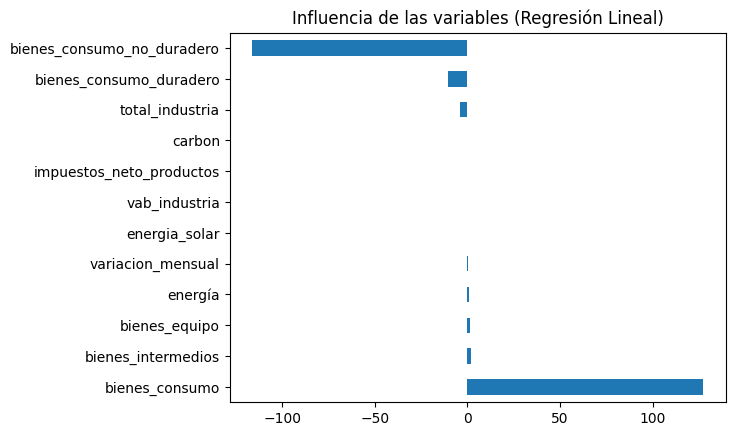

In [6]:
from sklearn.linear_model import LinearRegression

# Entrenar modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

# Ver coeficientes
importancia = pd.Series(modelo_lineal.coef_, index=X.columns)
importancia.sort_values(ascending=False).plot(kind='barh', title='Influencia de las variables (Regresión Lineal)')


## Paso 5: Selección de las variables más influyentes

Se seleccionan las 7 variables con mayor valor absoluto de coeficiente para simplificar el modelo y evitar sobreajuste.


In [7]:
top_vars = importancia.abs().sort_values(ascending=False).head(7).index
X_reducido = X[top_vars]


## Paso 6: División del conjunto de datos

Se divide el conjunto reducido (`X_reducido`) en dos subconjuntos:
- 80% para entrenamiento del modelo
- 20% para evaluación en test

La semilla aleatoria se fija con `random_state=42` para asegurar reproducibilidad.


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reducido, y, test_size=0.2, random_state=42)


## Paso 7: Entrenamiento de modelos base

Se entrenan tres modelos de regresión distintos para comparar su rendimiento:

- Regresión Lineal
- Random Forest
- Gradient Boosting


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("R² Regresión Lineal:", r2_score(y_test, y_pred_lr))
print("RMSE Regresión Lineal:", sqrt(mean_squared_error(y_test, y_pred_lr)))


R² Regresión Lineal: 0.6552367696173356
RMSE Regresión Lineal: 17.021376110293108


In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("R² Random Forest:", r2_score(y_test, y_pred_rf))
print("RMSE Random Forest:", sqrt(mean_squared_error(y_test, y_pred_rf)))


R² Random Forest: 0.7176274430598074
RMSE Random Forest: 15.404423178164334


In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("R² Gradient Boosting:", r2_score(y_test, y_pred_gb))
print("RMSE Gradient Boosting:", sqrt(mean_squared_error(y_test, y_pred_gb)))


R² Gradient Boosting: 0.731488851035135
RMSE Gradient Boosting: 15.02157114203195


### Resultados iniciales
Se observa que el modelo de Gradient Boosting presenta el mejor rendimiento en el conjunto de test, con el mayor R² y menor RMSE. Por ello, se procede a su optimización.


## Paso 8: Optimización del modelo con GridSearchCV

Se aplica una búsqueda en rejilla (`GridSearchCV`) para encontrar los mejores hiperparámetros del modelo `GradientBoostingRegressor`.  
Se utiliza validación cruzada con 5 particiones (5-fold CV) y como métrica de evaluación el **coeficiente de determinación R²**.

Los hiperparámetros ajustados son:

- `n_estimators`: número de árboles
- `learning_rate`: tasa de aprendizaje
- `max_depth`: profundidad máxima de cada árbol
- `subsample`: fracción de datos usada en cada árbol (técnica de regularización)


In [12]:
from sklearn.model_selection import GridSearchCV

# Modelo base
gb_model = GradientBoostingRegressor(random_state=42)

# Espacio de búsqueda
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0]
}

# Búsqueda en rejilla
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_reducido, y)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100, 150],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=1)

In [13]:
# Mejor combinación encontrada
print("Mejores hiperparámetros:", grid_search.best_params_)
print("R² medio en CV:", grid_search.best_score_)

# Modelo final optimizado
mejor_modelo = grid_search.best_estimator_

# Evaluación en conjunto de test
y_pred_opt = mejor_modelo.predict(X_test)

print("R² (modelo optimizado):", r2_score(y_test, y_pred_opt))
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred_opt)))


Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}
R² medio en CV: -0.8962937387745292
R² (modelo optimizado): 0.8924874437578412
RMSE: 9.505255418361289


### Resultados de la optimización

El modelo optimizado con Gradient Boosting mejora significativamente el rendimiento predictivo, alcanzando un R² cercano al 0.89 y un RMSE notablemente inferior.

Se guarda el modelo final para su reutilización y se aplica a nuevos datos reales en el siguiente paso.


## Paso 9: Aplicación del modelo a datos nuevos

Se carga un archivo externo con nuevas observaciones para predecir el Índice de Producción Industrial (IPI) usando el modelo optimizado.

El archivo debe contener las mismas columnas predictoras que se usaron para entrenar el modelo (`X_reducido.columns`).

Las predicciones se almacenan en una nueva columna llamada `IPI_predicho`.


In [15]:
from google.colab import files
files.upload()

# Cargar archivo nuevo
df_nuevo = pd.read_excel('data_reducida_pruebaModelo.xlsx')

# Asegurarse de usar solo las columnas que espera el modelo
columnas_modelo = list(X_reducido.columns)
X_nuevo = df_nuevo[columnas_modelo]

# Predecir
df_nuevo['IPI_predicho'] = mejor_modelo.predict(X_nuevo)

# Ver resultados
df_nuevo[['IPI_predicho']].head()


Saving data_reducida_pruebaModelo.xlsx to data_reducida_pruebaModelo.xlsx


,IPI_predicho
0,62.392522
1,69.464514
2,69.674280
3,73.028353
4,85.194288


In [16]:
df_nuevo.to_excel('predicciones_IPI_resultado.xlsx', index=False)


### Resultado

El modelo predice satisfactoriamente el valor del IPI para nuevas observaciones. El resultado se guarda como archivo Excel para su posterior análisis o uso externo.
